In [1]:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')


%cd ../../
from fraudes.python.utils.conection import read_table_from_bd
from fraudes.python.utils.grafic import raincloud_image
from fraudes.python.utils.correlaciones import correlaciones_chi2
from fraudes.python.utils.prepocesar_data import prepocesar_data

C:\Users\Asus\Documents\proyectos\fraudes


In [2]:
fraudes = read_table_from_bd()

In [3]:
fraudes.size

508860

In [4]:
fraudes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   monthh                15420 non-null  object
 1   weekofmonth           15420 non-null  int64 
 2   dayofweek             15420 non-null  object
 3   make                  15420 non-null  object
 4   accidentarea          15420 non-null  object
 5   dayofweekclaimed      15420 non-null  object
 6   monthclaimed          15420 non-null  object
 7   weekofmonthclaimed    15420 non-null  int64 
 8   sex                   15420 non-null  object
 9   maritalstatus         15420 non-null  object
 10  age                   15420 non-null  int64 
 11  fault                 15420 non-null  object
 12  policytype            15420 non-null  object
 13  vehiclecategory       15420 non-null  object
 14  vehicleprice          15420 non-null  object
 15  fraudfound_p          15420 non-null

In [5]:
cols = ['monthh', 'weekofmonth', 'dayofweek',]
agg = {'fraudfound_p': [sum, 'count']}
week_day = fraudes.groupby(cols).agg(agg)
week_day.columns = ['suma', 'cantidad']
week_day.reset_index(inplace=True)

week_day['percentage_fraud_week_day'] = week_day['suma'] /week_day['cantidad'] * 100
week_day['percentage_fraud_week_day'] = week_day['percentage_fraud_week_day'].round(2)

cols = ['monthh', 'weekofmonth']
agg = {'fraudfound_p': [sum, 'count']}
weekofmonth = fraudes.groupby(cols).agg(agg)
weekofmonth.columns = ['suma', 'cantidad']
weekofmonth.reset_index(inplace=True)

weekofmonth['percentage_fraud_weekofmonth'] = weekofmonth['suma'] /weekofmonth['cantidad'] * 100
weekofmonth['percentage_fraud_weekofmonth'] = weekofmonth['percentage_fraud_weekofmonth'].round(2)

cols = ['monthh']
agg = {'fraudfound_p': [sum, 'count']}
mes = fraudes.groupby(cols).agg(agg)
mes.columns = ['suma', 'cantidad']
mes.reset_index(inplace=True)

mes['percentage_fraud_month'] = mes['suma'] /mes['cantidad'] * 100
mes['percentage_fraud_month'] = mes['percentage_fraud_month'].round(2)

consulta = pd.merge(
    week_day[['monthh', 'weekofmonth', 'dayofweek','percentage_fraud_week_day']],
    weekofmonth[['monthh', 'weekofmonth','percentage_fraud_weekofmonth']],
    on=['monthh', 'weekofmonth'])

consulta = pd.merge(
    consulta,
    mes[['monthh', 'percentage_fraud_month']],
    on=['monthh'])

cols_ord = [
    'monthh',
    'weekofmonth',
    'dayofweek',
    'percentage_fraud_month',
    'percentage_fraud_weekofmonth',
    'percentage_fraud_week_day' ]
consulta = consulta[cols_ord]
consulta

,monthh,weekofmonth,dayofweek,percentage_fraud_month,percentage_fraud_weekofmonth,percentage_fraud_week_day
0,Apr,1,Friday,6.25,6.64,9.52
1,Apr,1,Monday,6.25,6.64,8.33
2,Apr,1,Saturday,6.25,6.64,5.77
3,Apr,1,Sunday,6.25,6.64,2.33
4,Apr,1,Thursday,6.25,6.64,7.69
...,...,...,...,...,...,...
389,Sep,4,Wednesday,6.13,4.26,0.00
390,Sep,5,Friday,6.13,5.56,6.67
391,Sep,5,Saturday,6.13,5.56,7.69
392,Sep,5,Thursday,6.13,5.56,2.17


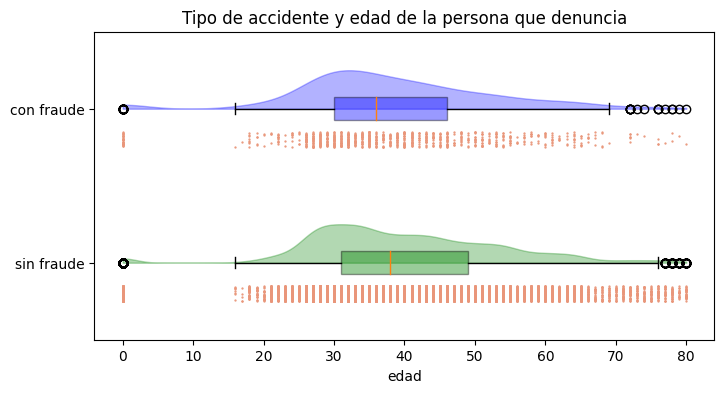

In [6]:
sin_fraude = fraudes[fraudes.fraudfound_p==0]
con_fraude = fraudes[fraudes.fraudfound_p==1]
data_x = [sin_fraude.age.to_numpy(), con_fraude.age.to_numpy()]
feats = ['sin fraude', 'con fraude']
value = 'edad'
title = 'Tipo de accidente y edad de la persona que denuncia'

raincloud_image(data_x, feats, value, title)

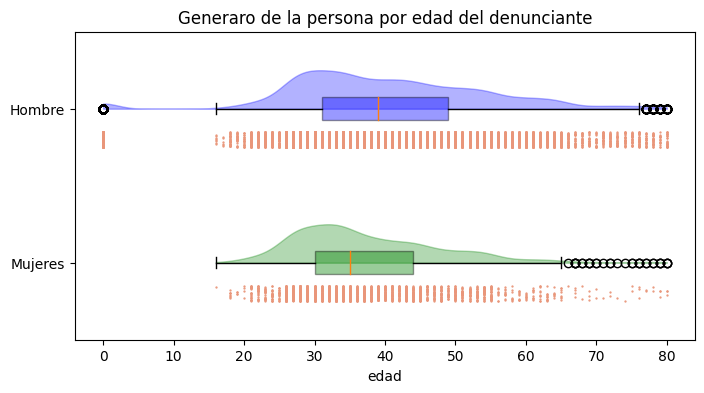

In [7]:
female_fraude = fraudes[fraudes.sex=='Female']
male_fraude = fraudes[fraudes.sex=='Male']
data_x = [female_fraude.age.to_numpy(), male_fraude.age.to_numpy()]
feats = ['Mujeres', 'Hombre']
value = 'edad'
title = 'Generaro de la persona por edad del denunciante'

raincloud_image(data_x, feats, value, title)

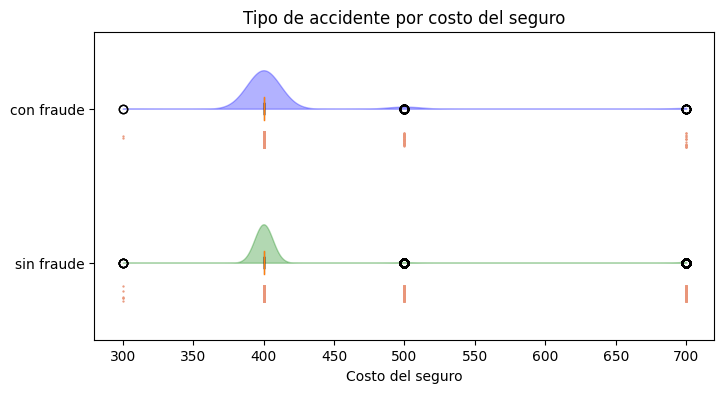

In [8]:
sin_fraude = fraudes[fraudes.fraudfound_p==0]
con_fraude = fraudes[fraudes.fraudfound_p==1]
data_x = [sin_fraude.deductible.to_numpy(), con_fraude.deductible.to_numpy()]
feats = ['sin fraude', 'con fraude']
value = 'Costo del seguro'
title = 'Tipo de accidente por costo del seguro'

raincloud_image(data_x, feats, value, title)

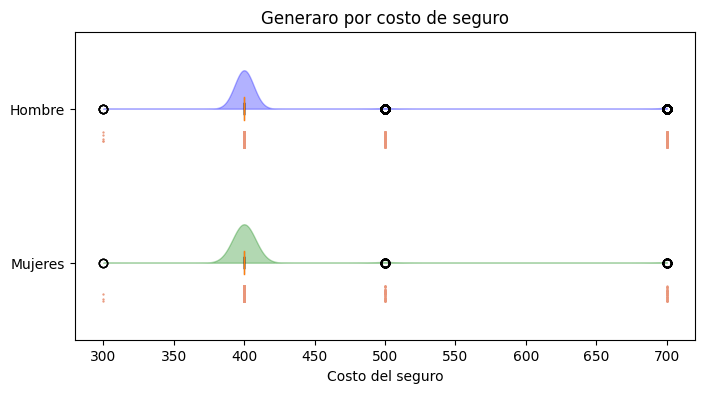

In [9]:
female_fraude = fraudes[fraudes.sex=='Female']
male_fraude = fraudes[fraudes.sex=='Male']
data_x = [female_fraude.deductible.to_numpy(), male_fraude.deductible.to_numpy()]
feats = ['Mujeres', 'Hombre']
value = 'Costo del seguro'
title = 'Generaro por costo de seguro'

raincloud_image(data_x, feats, value, title)

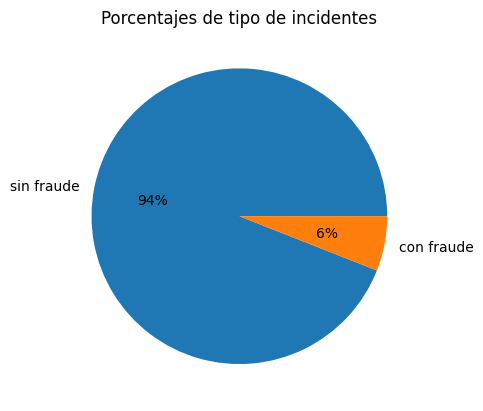

In [10]:
# declaring data
group_fraudes = fraudes.groupby('fraudfound_p').agg({'fraudfound_p':'count'})
group_fraudes.columns = ['cantidad']
group_fraudes.reset_index(inplace=True)
group_fraudes['fraudfound_p'] = group_fraudes['fraudfound_p'].replace(
    {0: 'sin fraude', 1:'con fraude'})

explode = [0, 0.1, 0, 0, 0]
plt.title('Porcentajes de tipo de incidentes')
plt.pie(group_fraudes.cantidad.tolist(), labels=group_fraudes.fraudfound_p.tolist(), autopct='%.0f%%')
  
# displaying chart
plt.show()

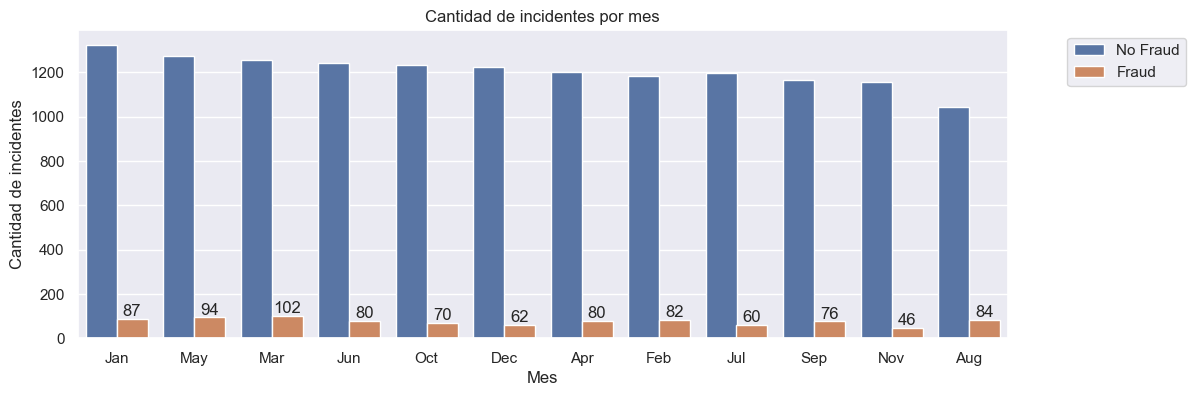

In [11]:
plt.figure(figsize=(12, 4))
sns.set(style='darkgrid')
labels = ['No Fraud', 'Fraud']
fig = sns.countplot(x="monthh", hue ='fraudfound_p', data=fraudes, order = fraudes['monthh'].value_counts().index)
fig.bar_label(fig.containers[1], label_type='edge');

plt.legend(labels,  bbox_to_anchor=(1.2, 1))
plt.title('Cantidad de incidentes por mes')
plt.ylabel('Cantidad de incidentes')
plt.xlabel('Mes')
plt.show()

In [12]:
cols = ['monthh', 'yearr', 'fraudfound_p']
agg = {'fraudfound_p': 'count'}
year_month = fraudes.groupby(cols).agg(agg)
year_month.columns = ['cantidad']
year_month.reset_index(inplace=True)
year_month_fraude = year_month[year_month.fraudfound_p==1]
year_month_fraude.sort_values('cantidad', ascending=False)

,monthh,yearr,fraudfound_p,cantidad
7,Aug,1994,1,56
41,Mar,1994,1,56
47,May,1994,1,52
61,Oct,1995,1,50
25,Jan,1994,1,48
1,Apr,1994,1,47
35,Jun,1994,1,47
43,Mar,1995,1,45
21,Feb,1995,1,45
15,Dec,1995,1,44


In [13]:
cols = ['make', 'fraudfound_p']
agg = {'fraudfound_p': 'count'}
make_group = fraudes.groupby(cols).agg(agg)
make_group.columns = ['cantidad']
make_group.reset_index(inplace=True)
make_group.sort_values(['fraudfound_p','cantidad'], ascending=False)[:10]

,make,fraudfound_p,cantidad
24,Pontiac,1,213
31,Toyota,1,186
12,Honda,1,179
16,Mazda,1,123
5,Chevrolet,1,94
1,Accura,1,59
10,Ford,1,33
27,Saab,1,11
33,VW,1,8
20,Mercury,1,6


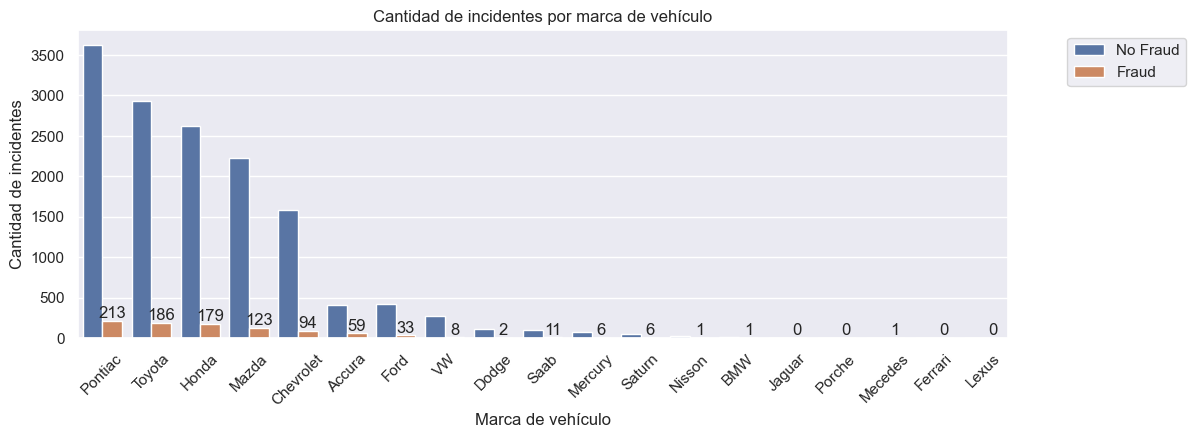

In [14]:
plt.figure(figsize=(12, 4))
sns.set(style='darkgrid')
labels = ['No Fraud', 'Fraud']
fig = sns.countplot(x="make", hue ='fraudfound_p', data=fraudes, order = fraudes['make'].value_counts().index)
fig.bar_label(fig.containers[1], label_type='edge');

plt.legend(labels,  bbox_to_anchor=(1.2, 1))
plt.title('Cantidad de incidentes por marca de vehículo')

plt.ylabel('Cantidad de incidentes')
plt.xlabel('Marca de vehículo')
plt.xticks(rotation=45)
plt.show()

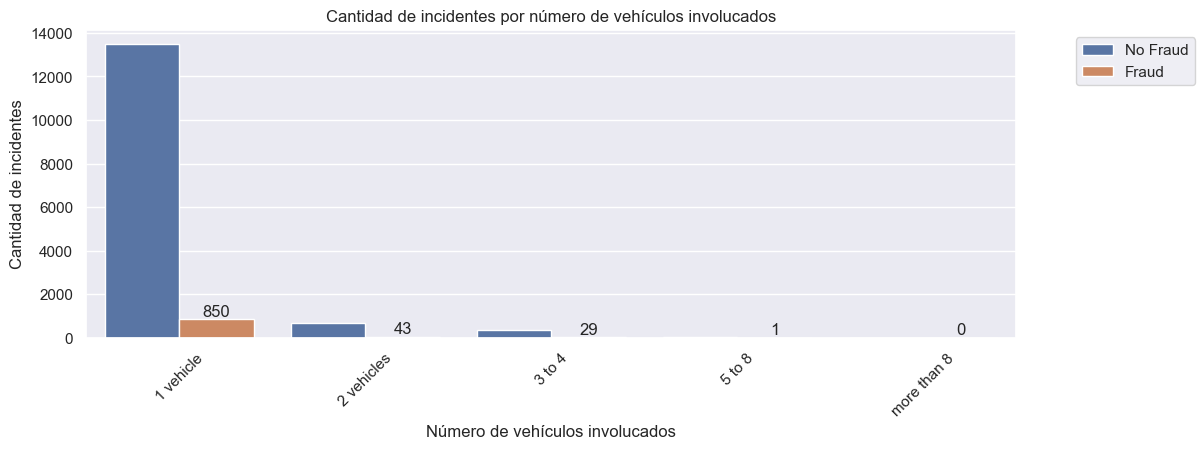

In [15]:
plt.figure(figsize=(12, 4))
sns.set(style='darkgrid')
labels = ['No Fraud', 'Fraud']
fig = sns.countplot(x="numberofcars", hue ='fraudfound_p', data=fraudes, order = fraudes['numberofcars'].value_counts().index)
fig.bar_label(fig.containers[1], label_type='edge');

plt.legend(labels,  bbox_to_anchor=(1.2, 1))
plt.title('Cantidad de incidentes por número de vehículos involucados')

plt.ylabel('Cantidad de incidentes')
plt.xlabel('Número de vehículos involucados')
plt.xticks(rotation=45)
plt.show()

In [16]:
fraudes.basepolicy.unique()

array(['Liability', 'Collision', 'All Perils'], dtype=object)

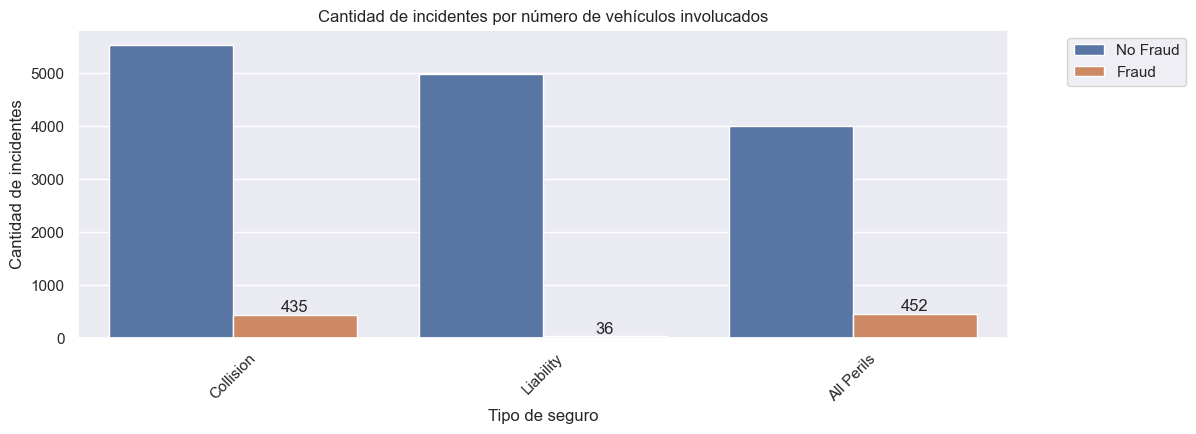

In [17]:
plt.figure(figsize=(12, 4))
sns.set(style='darkgrid')
labels = ['No Fraud', 'Fraud']
fig = sns.countplot(x="basepolicy", hue ='fraudfound_p', data=fraudes, order = fraudes['basepolicy'].value_counts().index)
fig.bar_label(fig.containers[1], label_type='edge');

plt.legend(labels,  bbox_to_anchor=(1.2, 1))
plt.title('Cantidad de incidentes por número de vehículos involucados')

plt.ylabel('Cantidad de incidentes')
plt.xlabel('Tipo de seguro')
plt.xticks(rotation=45)
plt.show()

In [18]:
fraudes_str = fraudes.select_dtypes(include=['object'])

In [19]:
correlaciones_chi2 = correlaciones_chi2(fraudes_str,fraudes)
   

In [20]:
correlaciones_chi2

{'monthh': 0.002,
 'make': 0.0,
 'accidentarea': 0.0,
 'monthclaimed': 0.0,
 'sex': 0.0,
 'fault': 0.0,
 'policytype': 0.0,
 'vehiclecategory': 0.0,
 'vehicleprice': 0.0,
 'days_policy_accident': 0.021,
 'pastnumberofclaims': 0.0,
 'ageofvehicle': 0.003,
 'ageofpolicyholder': 0.0,
 'agenttype': 0.007,
 'numberofsuppliments': 0.0,
 'addresschange_claim': 0.0,
 'basepolicy': 0.0}

In [21]:
cols_str = list(correlaciones_chi2.keys())
cols_num = ['age', 'fraudfound_p', 'deductible', 'driverrating', 'yearr']
sel_cols =  cols_str + cols_num
fraudes_model = fraudes.loc[:, sel_cols]
cond_edad = fraudes_model['age'] >= 17
fraudes_model = fraudes_model[cond_edad]

In [77]:
fraudes_model.fraudfound_p.value_counts()

fraudfound_p
0    14200
1      891
Name: count, dtype: int64

In [23]:
fraudes_model.to_dict('records')[0]

{'monthh': 'Dec',
 'make': 'Honda',
 'accidentarea': 'Urban',
 'monthclaimed': 'Jan',
 'sex': 'Female',
 'fault': 'Policy Holder',
 'policytype': 'Sport - Liability',
 'vehiclecategory': 'Sport',
 'vehicleprice': 'more than 69000',
 'days_policy_accident': 'more than 30',
 'pastnumberofclaims': 'none',
 'ageofvehicle': '3 years',
 'ageofpolicyholder': '26 to 30',
 'agenttype': 'External',
 'numberofsuppliments': 'none',
 'addresschange_claim': '1 year',
 'basepolicy': 'Liability',
 'age': 21,
 'fraudfound_p': 0,
 'deductible': 300,
 'driverrating': 1,
 'yearr': 1994}

In [24]:
X = prepocesar_data(fraudes_model) #conjunto para entrenar procesados
X.drop('fraudfound_p', axis=1, inplace=True)
y = fraudes_model.fraudfound_p

C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2023)



In [27]:
from sklearn.tree import DecisionTreeClassifier


#Números enteros de 1 a 50
max_depth_values = np.arange(1, 51, 1)

#Arreglos vacíos para almacenar el error de entrenamiento y el de generalización.
train_error = np.empty(len(max_depth_values))
generalization_error = np.empty(len(max_depth_values))


for depth in max_depth_values:
    #Entrenamos
    decision_tree = DecisionTreeClassifier(max_depth = depth)
    decision_tree.fit(X_train, y_train)
    train_error[depth - 1] = (1 - decision_tree.score(X_train, y_train))
    generalization_error[depth - 1] = (1 - decision_tree.score(X_test, y_test))

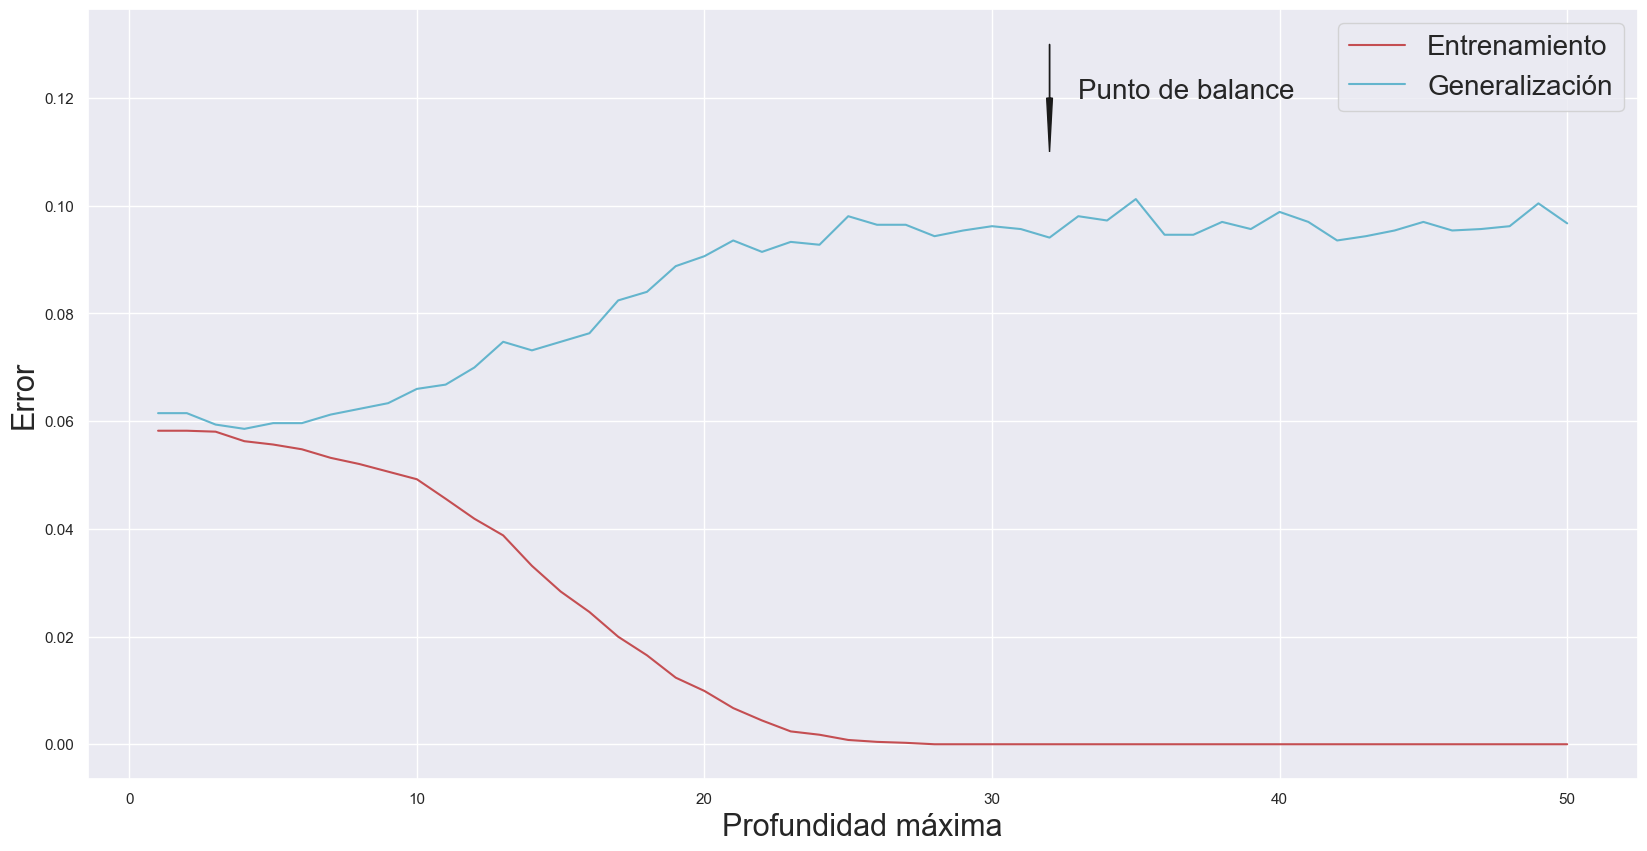

In [28]:
plt.figure(figsize=(20,10))
plt.plot(max_depth_values, train_error, label="Entrenamiento", c='r')
plt.plot(max_depth_values, generalization_error, label="Generalización",c='c')
#plt.xticks(max_depth_values)
plt.xlabel("Profundidad máxima",fontsize=22); 
plt.ylabel("Error",fontsize=22);
plt.arrow(32, 0.13, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
plt.text(33, 0.12, 'Punto de balance',fontsize=20)

plt.legend(fontsize=20);

In [29]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth         = 32,
            criterion         = 'gini',
            random_state      = 2023
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=32, random_state=2023)

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Error de test del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test)

print("Matriz de confusión")
print("-------------------")
confusion_matrix(y_true=y_test, y_pred=predicciones)

Matriz de confusión
-------------------


array([[3348,  193],
       [ 172,   60]], dtype=int64)

In [32]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {np.round(100 * accuracy,1)} %")

El accuracy de test es: 90.3 %


In [39]:
# Predicción de probabilidades
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test)
predicciones

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:
pd.DataFrame(predicciones)

,0
0,0
1,0
2,0
3,0
4,1
...,...
3768,0
3769,0
3770,0
3771,0


In [44]:
from joblib import dump
from joblib import load

In [45]:
dump(modelo, 'model.pkl')

['model.pkl']

In [48]:
modelo_load = load('model.pkl')

In [49]:
modelo_load

DecisionTreeClassifier(max_depth=32, random_state=2023)

In [50]:
predicciones_load = modelo_load.predict(X = X_test)
predicciones_load

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [51]:
pd.DataFrame(predicciones_load)

,0
0,0
1,0
2,0
3,0
4,1
...,...
3768,0
3769,0
3770,0
3771,0


In [53]:
nuevo1 = fraudes_model.to_dict('records')[0]

In [74]:
nuevo1

{'monthh': 'Dec',
 'make': 'Honda',
 'accidentarea': 'Urban',
 'monthclaimed': 'Jan',
 'sex': 'Female',
 'fault': 'Policy Holder',
 'policytype': 'Sport - Liability',
 'vehiclecategory': 'Sport',
 'vehicleprice': 'more than 69000',
 'days_policy_accident': 'more than 30',
 'pastnumberofclaims': 'none',
 'ageofvehicle': '3 years',
 'ageofpolicyholder': '26 to 30',
 'agenttype': 'External',
 'numberofsuppliments': 'none',
 'addresschange_claim': '1 year',
 'basepolicy': 'Liability',
 'age': 21,
 'fraudfound_p': 0,
 'deductible': 300,
 'driverrating': 1,
 'yearr': 1994}

In [58]:
df_nuevo = pd.DataFrame([nuevo1])

In [68]:
total_fraudes = pd.concat([fraudes_model, df_nuevo])
total_fraudes.drop('fraudfound_p', axis=1, inplace=True)
total_fraudes.drop_duplicates(inplace=True)

In [69]:
X_nuevo = prepocesar_data(total_fraudes)

C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [70]:
X_nuevo = X_nuevo.tail(1)

In [71]:
X_nuevo

,age,deductible,driverrating,yearr,monthh_Apr,monthh_Aug,monthh_Dec,monthh_Feb,monthh_Jan,monthh_Jul,...,numberofsuppliments_more than 5,numberofsuppliments_none,addresschange_claim_1 year,addresschange_claim_2 to 3 years,addresschange_claim_4 to 8 years,addresschange_claim_no change,addresschange_claim_under 6 months,basepolicy_All Perils,basepolicy_Collision,basepolicy_Liability
15087,-1.603164,-0.17746,1.349184,1.407444,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [73]:
predicciones_load = modelo_load.predict(X=X_nuevo)
predicciones_load[0]

1

In [47]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [101]:
# Creating a list of classifiers
classifiers = [
    LogisticRegression(max_iter=1000),
    SVC(max_iter=1000),
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    KNeighborsClassifier(),
    GaussianNB(),
    GradientBoostingClassifier()]

# Creating a stratified k-fold object with 5 splits
skf = StratifiedKFold(n_splits=5)

# Looping over the classifiers
for clf in classifiers:
    # Initializing empty lists to store the evaluation metrics for each fold
    accuracies = []
    precisions = []
    recalls = []

    # Fitting the classifier on the train set
    clf.fit(X_train, y_train)
    # Predicting on the test set
    y_pred = clf.predict(X_test)
    # Calculating the evaluation metrics and appending them to the respective lists
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    # Printing the mean and standard deviation of the evaluation metrics for each classifier
    print(f"{clf.__class__.__name__}")
    print(f"El accuracy de test es: {np.round(100 * accuracy,1)} %")
    print(f"El precision de test es: {np.round(100 * precision,1)} %")
    print(f"El recall de test es: {np.round(100 * recall,1)} %")
    print("Matriz de confusión")
    print("-------------------")
    conf = confusion_matrix(
        y_true=y_test,
        y_pred=y_pred)
    print(conf)


LogisticRegression
El accuracy de test es: 93.7 %
El precision de test es: 0.0 %
El recall de test es: 0.0 %
Matriz de confusión
-------------------
[[3536    5]
 [ 232    0]]


C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC
El accuracy de test es: 93.9 %
El precision de test es: 0.0 %
El recall de test es: 0.0 %
Matriz de confusión
-------------------
[[3541    0]
 [ 232    0]]
DecisionTreeClassifier
El accuracy de test es: 90.0 %
El precision de test es: 22.7 %
El recall de test es: 25.9 %
Matriz de confusión
-------------------
[[3337  204]
 [ 172   60]]
RandomForestClassifier
El accuracy de test es: 93.9 %
El precision de test es: 55.6 %
El recall de test es: 2.2 %
Matriz de confusión
-------------------
[[3537    4]
 [ 227    5]]
KNeighborsClassifier
El accuracy de test es: 93.5 %
El precision de test es: 29.4 %
El recall de test es: 4.3 %
Matriz de confusión
-------------------
[[3517   24]
 [ 222   10]]
GaussianNB
El accuracy de test es: 13.3 %
El precision de test es: 6.5 %
El recall de test es: 98.7 %
Matriz de confusión
-------------------
[[ 273 3268]
 [   3  229]]
GradientBoostingClassifier
El accuracy de test es: 94.2 %
El precision de test es: 88.9 %
El recall de test es: 6.9 %
Matriz de 

In [102]:
df = pd.read_csv('https://jdrincone.s3.us-east-2.amazonaws.com/fraud.csv')

In [103]:
df

,Monthh,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Yearr,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils


In [29]:
#####Pipeline
fraudes_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15091 entries, 0 to 15419
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   monthh                15091 non-null  object
 1   make                  15091 non-null  object
 2   accidentarea          15091 non-null  object
 3   monthclaimed          15091 non-null  object
 4   sex                   15091 non-null  object
 5   fault                 15091 non-null  object
 6   policytype            15091 non-null  object
 7   vehiclecategory       15091 non-null  object
 8   vehicleprice          15091 non-null  object
 9   days_policy_accident  15091 non-null  object
 10  pastnumberofclaims    15091 non-null  object
 11  ageofvehicle          15091 non-null  object
 12  ageofpolicyholder     15091 non-null  object
 13  agenttype             15091 non-null  object
 14  numberofsuppliments   15091 non-null  object
 15  addresschange_claim   15091 non-null  obj

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [41]:
X = fraudes_model.drop('fraudfound_p', axis=1)
y = fraudes_model['fraudfound_p']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

numeric_cols = X.select_dtypes(include=["int64", "int"]).columns.to_list()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.to_list()
model = Pipeline([
    ("scale", StandardScaler(), numeric_cols),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols),
    ("classifier", LogisticRegression(max_iter=1000))
])
model.fit(X_train, y_train)

ValueError: too many values to unpack (expected 2)